# COMP3271 - Introduction to Music Computing 
## Intervals, Chords and Scales: Working with MIDI files

Eamonn Bell  
<eamonn.bell@durham.ac.uk>

2024-12-05 (rev. 1)

By the end of this practical you should able to:

- understand how to compute melodic and harmonic intervals
- understand the basics of piano-roll representations of symbolic music data
- load a MIDI file into a suitable data structure
- play back a MIDI file for audition
- compute summary statistics over a collection of MIDI files

This notebook is for non-commercial use only, and freely adapts some material from:

- Colin Raffel, `pretty_midi` [[github]](https://github.com/craffel/pretty-midi/) (Code: MIT License)


In [1]:
from matplotlib import pylab as plt
import matplotlib
import itertools
import numpy as np
import pretty_midi
import IPython.display as ipd

## 1. Measuring intervals and their consonance

Here is some code that generates melodies, by walking up and down a set of notes generated by applying a scale template to a starting pitch (expressed as MIDI note number).

In [2]:
MAJOR_SCALE_TEMPLATE = [2, 2, 1, 2, 2, 2, 1]
PENTATONIC_SCALE_TEMPLATE = [2, 2, 3, 2, 3]

def generate_line(start_mnn=69, length=20, scale_template=MAJOR_SCALE_TEMPLATE, min_step=1, max_step=5):
    scale = [start_mnn]
    for step in scale_template:
        scale = [scale[0] - step] + scale + [scale[-1] + step]
    
    melody = []
    current_index = scale.index(start_mnn)
    for _ in range(length - 1):
        step_size = np.random.randint(abs(min_step), abs(max_step + 1))
        direction = np.random.choice([-1, 1])
        next_index = current_index + step_size * direction

        next_index = max(0, min(next_index, len(scale) - 1))

                
        next_note = scale[next_index]
        melody.append(next_note)
        current_index = next_index
    
    return melody

This produces a sequence of notes, and, by extension, a sequence of **melodic** intervals between directly successive notes.

In [3]:
generate_line()

[62, 57, 65, 71, 67, 65, 57, 58, 57, 57, 57, 65, 73, 81, 81, 81, 74, 65, 64]

Let's call a "score" a 2D array of melody lines stacked on top of each other. In this case, the columns will be heard simultaneously. This produces a set of **harmonic** intervals between simultaneous notes.

In [4]:
num_lines = 4
np.stack([generate_line() for _ in range(num_lines)])

array([[78, 81, 81, 81, 81, 74, 65, 62, 65, 67, 74, 65, 60, 57, 57, 57,
        62, 65, 60],
       [78, 80, 71, 76, 67, 64, 71, 76, 80, 81, 76, 73, 67, 69, 76, 71,
        78, 71, 76],
       [76, 80, 73, 64, 62, 57, 62, 67, 73, 69, 65, 74, 80, 76, 78, 76,
        81, 81, 78],
       [62, 69, 71, 65, 69, 78, 69, 74, 80, 81, 81, 76, 71, 67, 73, 69,
        73, 74, 67]])

Write a function `measure_melodic_consonance` that accepts a "score" (a 2D array of MIDI note numbers) and returns an aggregate measure of the consonance of the melodic intervals formed between directly successive notes in every line of the score.

You should use the array `CONSONANCE_SCORES`, which provides a measure for the consonance/dissonance of each of the 12 pitch interval classes (remembering that octave equivalence means that a major second is qualitiatively similar to the interval that is a perfect octave plus a major second).

In [5]:
CONSONANCE_SCORES = np.array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [6]:
def measure_melodic_consonance(score):
    intervals = np.diff(score)
    interval_sizes = intervals % 12
    return np.sum(CONSONANCE_SCORES[interval_sizes]) / score.size

Write a function `measure_harmonic_consonance` that accepts a "score" (a 2D array of MIDI note numbers) and returns an aggregate measure of the consonance of the harmonic intervals formed between all pairwise combinations of lines, considered one note at at time.  

In [7]:
def measure_harmonic_consonance(score):
    running_score = 0
    total_size = 0

    for pair in itertools.combinations(np.arange(score.shape[0]), 2):
        intervals = np.diff(score[pair,:], axis=0)
        interval_sizes = intervals % 12
        running_score += np.sum(CONSONANCE_SCORES[interval_sizes])
        total_size += intervals.size

    return running_score / total_size

Once we have this code, we scan start to investigate the link between scale choice and some notion of "overall" consonance, keeping the melody generation process fixed.

The following code repeatedly generates a melody and computes both the melodic and consonance measures you have defined above. You can pass keyword arguments for `generate_melody` into `experiment`.

In [8]:
def experiment(runs=1000, lines=2, **kwargs):
    C_m = []
    C_h = []

    for _ in range(runs):
        score = np.stack([generate_line(**kwargs) for _ in range(lines)])
        C_m.append(measure_melodic_consonance(score))
        C_h.append(measure_harmonic_consonance(score))

    return C_m, C_h

In this case, we want to understand the effect of choosing a given scale on the overall consonance of "scores" generated from walks up and down that scale.

In [9]:
C_m_major, C_h_major = experiment(scale_template=MAJOR_SCALE_TEMPLATE)
C_m_pentatonic, C_h_pentatonic = experiment(scale_template=PENTATONIC_SCALE_TEMPLATE)

In [10]:
max(C_h_pentatonic)

1.0

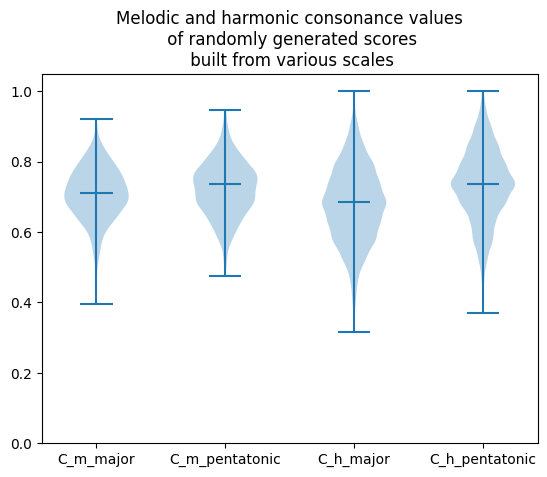

In [11]:
data = [C_m_major, C_m_pentatonic, C_h_major, C_h_pentatonic]
labels = ['C_m_major', 'C_m_pentatonic', 'C_h_major', 'C_h_pentatonic']

plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3, 4], labels)
plt.ylim(0, 1.05)
plt.title("Melodic and harmonic consonance values\n of randomly generated scores\n built from various scales")
plt.show()

## 2. Creating MIDI files using `pretty_midi`

Now, we would like to listen to some of the scores we have been generating. 

`pretty_midi` is a library developed by Colin Raffel, which is designed to make working with MIDI files a lot more straightforward. The principal benefit is that it takes care of the arithmetic required to convert between MIDI file representations and the piano-roll representation.

The library itself is well-written, so we can learn something from looking at the definition of the `Note` class, which encapsulates the information needed to model a musical note in MIDI: 

- the velocity (intensity) of the node
- the pitch (as MIDI note number)
- the time of the note on event (in seconds)
- the time of the note off event (in seconds)

```python
class Note(object):
    """A note event.

    Parameters
    ----------
    velocity : int
        Note velocity.
    pitch : int
        Note pitch, as a MIDI note number.
    start : float
        Note on time, absolute, in seconds.
    end : float
        Note off time, absolute, in seconds.

    """

    def __init__(self, velocity, pitch, start, end):
        if end < start:
            raise ValueError("Note end time must be greater than start time")
        
        self.velocity = velocity
        self.pitch = pitch
        self.start = start
        self.end = end

    def get_duration(self):
        """Get the duration of the note in seconds."""
        return self.end - self.start

    @property
    def duration(self):
        return self.get_duration()

    def __repr__(self):
        return 'Note(start={:f}, end={:f}, pitch={}, velocity={})'.format(
            self.start, self.end, self.pitch, self.velocity)

```

The `PrettyMIDI` class is the main container in `pretty_midi`. It stores not only all of the events that constitute the piece, but also all of the timing information and utility functions for manipulating, writing out, and inferring information about the MIDI data it contains.

One of the most important functions of the `PrettyMIDI` is to hold a list of `Instrument` class instances. Each `Instrument` is able to store different events (for example, notes) which are meant to be played on a given general MIDI instrument (for example, instrument 42, "Cello"). 

In [12]:
pm = pretty_midi.PrettyMIDI()
instrument1 = pretty_midi.Instrument(program=42)
instrument2 = pretty_midi.Instrument(program=64)
instrument1.notes.append(pretty_midi.Note(velocity=127, pitch=69, start=0.1, end=0.5))
instrument2.notes.append(pretty_midi.Note(velocity=127, pitch=84, start=0.6, end=0.7))
pm.instruments.append(instrument1)
pm.instruments.append(instrument2)

We have been thinking so far in this practical about musical "scores" as arrays of MIDI note numbers which correspond to events of equal duration that are equally spaced out in time. Musical events that have this property are called **isochronous** events.

Let's look at the following function `build_midi` that takes as input a score in the simple format we have been working with (represented as a NumPy array filled with MIDI note numbers) and builds a PrettyMIDI object containing appropriate `Note` instances.

In [13]:
def build_midi(melody, velocity=100, note_duration=0.5):
    pm = pretty_midi.PrettyMIDI()

    for row in melody:
        curr_start = 0

        inst = pretty_midi.Instrument(program=42)
        for pitch in row:
            inst.notes.append(pretty_midi.Note(velocity=velocity, pitch=pitch, start=curr_start, end=curr_start + note_duration))
            curr_start += note_duration

        pm.instruments.append(inst)

    return pm

`pretty_midi` comes with a simple synthesize facility, which will take a `PrettyMidi` object and produce a time-domain audio representation, by default using a sine-tone generator to produce the pitches. You can use other functions to synthesise the sounds (e.g. square, triangle waves) if you like; these have different spectral properties, and hence give rise to different timbres (for the same set of notes). Make sure you have adjusted the volume on your headphones BEFORE playing the output of any cells containing audio!   

In [15]:
pm = build_midi([generate_line()])
ipd.Audio(pm.synthesize(fs=22050), rate=22050)

Of course, this does not respect any information on the `Instrument` object telling us about what MIDI programme (and/or instrument name) should be used in rendering the audio representation. Getting this to work on different platforms is suprisingly non-trivial but you can always create and save a MIDI file and play it in your computer's media player (e.g. VLC Player) or a DAW (e.g. Ableton Live, Ardour, GarageBand).

pretty_midi has other classes for holding MIDI events: namely `PitchBend`, and `ControlChange`. These classes store information analogous to their corresponding MIDI events. The `Instrument` class has separate lists for each of these event types. 

## 3. Plotting MIDI data

In [16]:
pm.instruments[0].notes

[Note(start=0.000000, end=0.500000, pitch=76, velocity=100),
 Note(start=0.500000, end=1.000000, pitch=80, velocity=100),
 Note(start=1.000000, end=1.500000, pitch=76, velocity=100),
 Note(start=1.500000, end=2.000000, pitch=81, velocity=100),
 Note(start=2.000000, end=2.500000, pitch=81, velocity=100),
 Note(start=2.500000, end=3.000000, pitch=76, velocity=100),
 Note(start=3.000000, end=3.500000, pitch=80, velocity=100),
 Note(start=3.500000, end=4.000000, pitch=74, velocity=100),
 Note(start=4.000000, end=4.500000, pitch=67, velocity=100),
 Note(start=4.500000, end=5.000000, pitch=65, velocity=100),
 Note(start=5.000000, end=5.500000, pitch=71, velocity=100),
 Note(start=5.500000, end=6.000000, pitch=76, velocity=100),
 Note(start=6.000000, end=6.500000, pitch=80, velocity=100),
 Note(start=6.500000, end=7.000000, pitch=73, velocity=100),
 Note(start=7.000000, end=7.500000, pitch=71, velocity=100),
 Note(start=7.500000, end=8.000000, pitch=62, velocity=100),
 Note(start=8.000000, en

Write a function `plot_piano_roll` that consumes a list of `Note` events, and draws a piano roll representation. 

Strictly speaking, a "piano roll" representation consists in a discrete set of events each with a start time, end time, pitch (expressed as MIDI note number) and (optionally) other parameters, such as the velocity. 

In [17]:
def plot_piano_roll(notelist):
    fig, ax = plt.subplots()
    for note in notelist:
        rect_patch = matplotlib.patches.Rectangle(
            (note.start, note.pitch),
            note.get_duration(),
            1,
            facecolor='r'
        )
        ax.add_patch(rect_patch)

    ax.set_xlim(0, max(note.end for note in notelist))
    ax.set_ylim(0, 127)

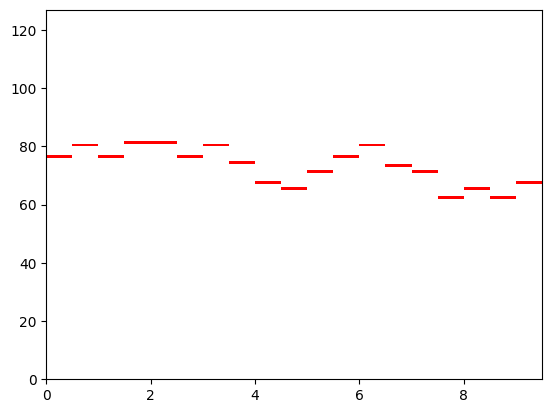

In [18]:
plot_piano_roll(pm.instruments[0].notes)

In [19]:
def notelist_to_matrix(notelist, tick_length):
    max_time = max(note.end for note in notelist)
    num_ticks = int(np.ceil(max_time / tick_length))
    
    piano_roll_matrix = np.zeros((128, num_ticks), dtype=int)
    
    for note in notelist:
        start_tick = int(note.start / tick_length)
        end_tick = int((note.end) / tick_length)
        piano_roll_matrix[note.pitch, start_tick:end_tick] = 1
    
    return piano_roll_matrix

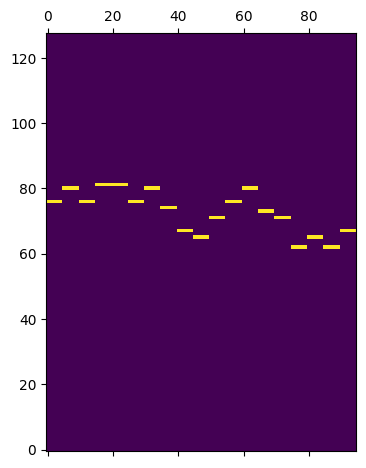

In [20]:
plt.matshow(notelist_to_matrix(pm.instruments[0].notes, tick_length=0.1), origin="lower")

`pretty_midi` (and most other research code) will loosely use the term piano roll representation to refer to a 2D matrix which is "hot" where a musical event is occuring and "cold" where it is not. However, it is important to understand that while working with matrixes in this way opens up the world of matrix operations and machine learning, we lose some of the semantics we had before. For eaxmple, two notes events that are directly sucessive and share the same pitch will not be distinguished in the matrix produced in this way. There are, of course, ways to preserve this information (e.g. in "channels", which could be implemented by adding another dimension to the matrix representation)

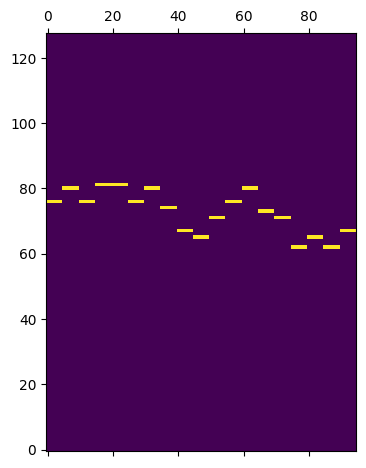

In [21]:
M_piano_roll = pm.get_piano_roll(fs=10)
plt.matshow(M_piano_roll, origin="lower")

There is an analogy between the matrix "piano-roll" and the log-spaced spectrogram representation, which allows us to straightforwardly define a symbolic equivalent to the chromagram:

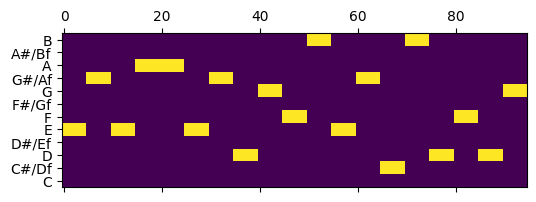

In [22]:
def symbolic_chromagram(matrix, n=12):
    n_rows, n_columns = matrix.shape
    result = np.zeros((n, n_columns))

    for i in range(n_rows):
        result[i % n, :] += matrix[i, :]

    return result

chroma_labels = ['C', 'C#/Df', 'D', 'D#/Ef', 'E', 'F', 'F#/Gf', 'G', 'G#/Af', 'A', 'A#/Bf', 'B']

fig, ax = plt.subplots(figsize=(6, 2))
cax = ax.matshow(symbolic_chromagram(M_piano_roll[:]), aspect='auto', origin="lower")

ax.set_yticks(np.arange(12))
ax.set_yticklabels(chroma_labels)


plt.show()

Finally, it is interesting to note that there are some very simple statistical analysis routines built into `pretty_midi`. For example, `get_pitch_class_histogram` can be used to tell us about the proportion of chroma in the MIDI file. If you run this against a MIDI file built from the output of the generation function, you can see the impact of shifting the starting MIDI note number on the chroma distribution (it should shift the distribution along the chroma axis cyclically).

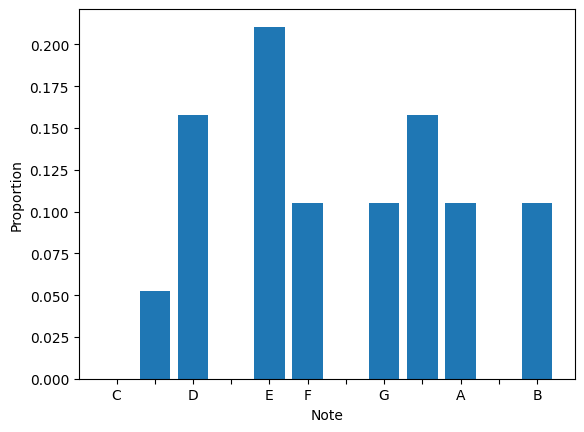

In [23]:
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')
plt.show()

## Bonus _Chord Catalog_

There is a piece of music by Tom Johnson, called _Chord Catalog_ (1986), which you can listen to on YouTube: https://www.youtube.com/embed/MkVTqZmOQvs?si=riq9ZJLIxfR94xR. The "score" for the work [is defined algorithmically](https://youtu.be/txTM4Ft2XZU?t=67) as follows:

> Play all the two-note chords possible in one octave, then the three-note chords, four-note chords, etc. ending with the one 13-note chord. Always begin with the lowest possible positions and move gradually up according to this rule: The lowest voice that can rise a half-tone does so and any lower voices descend to their points of departure. Each time that the top voice is going to rise a half-tone, one leaves a pause and begins a new section. 

The following code, which claims to implement this process, was adapted from the `pretty_midi` examples (and originated with [Douglas Repetto](douglasrepetto.com)).

If you find this kind of thing interesting, you should also [listen to](https://www.youtube.com/watch?v=AoMpPHnJCQE) Johnson's piece _Naryana's Cows_ (1989), which similarly implements an algorithmic process with a long pedigree and produces surprisingly engaging musical results.

In [24]:
def chord_catalog(chord_duration=0.2, note_duration_prop=0.8, max_size=5):
    STARTING_NOTE = 69
    VELOCITY = 100

    chord_duration = .2
    note_duration = chord_duration * note_duration_prop

    pm = pretty_midi.PrettyMIDI()
    pm.instruments.append(pretty_midi.Instrument(program=42))

    curr_time = 0.0

    for size in range(max_size):
        for offsets in itertools.combinations(range(1, 12), size):
            pm.instruments[0].notes.append(pretty_midi.Note(
                VELOCITY, STARTING_NOTE, curr_time, curr_time + note_duration))
            for offset in offsets:
                pm.instruments[0].notes.append(pretty_midi.Note(
                    VELOCITY, STARTING_NOTE + offset, curr_time, curr_time + note_duration))
            curr_time += chord_duration

    return pm

## 4. MIDI files "in the wild" with PrettyMIDI

In this section, we present a function `analyse_instrument_names` that consumes a list of file paths and produces results that compare any instruments that have a "name" in the MIDI source with the expected/reference name for that programme number, according to `pretty_midi`. Looking at MIDI files in this way, we can understand the degrees of "consensus" around how specific programme numbers are used. We also can start to examine the influence of different software, hardware, and localisation/internationalisation concerns on the production of MIDI files.

In [25]:
import glob
import pandas
from difflib import SequenceMatcher

fps = glob.glob("midi/*")

In [26]:
def analyse_instrument_names(fps):
    records = []
    for fp in fps:
        try:
            pm = pretty_midi.PrettyMIDI(fp)
            for instrument in pm.instruments:
                if instrument.name != '':
                    program_number = instrument.program
                    program_name = instrument.name
                    reference_name = pretty_midi.program_to_instrument_name(instrument.program)

                    matcher = SequenceMatcher(None, program_name, reference_name)
                    similarity = matcher.ratio()
                    
                    record = {
                        'program_number' : program_number,
                        'program_name' : program_name,
                        'reference_name' : reference_name,
                        'name_similarity': similarity
                    }
                records.append(record)
        except:
            pass
    return records

In [27]:
data = analyse_instrument_names(fps)

/home/rjbc76/mambaforge/envs/MuProcDurham/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


<Figure size 1200x800 with 0 Axes>

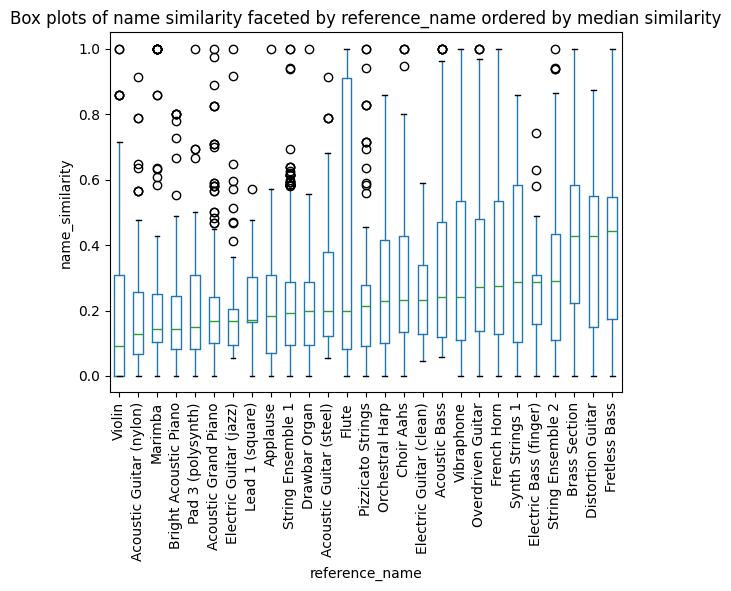

In [28]:
df = pandas.DataFrame(data)

filtered_df = df.groupby('reference_name').filter(lambda x: len(x) >= 75)

median_similarity = filtered_df.groupby('reference_name')['name_similarity'].median()
ordered_reference_names = median_similarity.sort_values().index

plt.figure(figsize=(12, 8))
filtered_df['reference_name'] = pandas.Categorical(filtered_df['reference_name'], categories=ordered_reference_names, ordered=True)
filtered_df.boxplot(by='reference_name', column=['name_similarity'], grid=False)

plt.xlabel('reference_name')
plt.ylabel('name_similarity')
plt.xticks(rotation=90)
plt.title('Box plots of name similarity faceted by reference_name ordered by median similarity')
plt.suptitle('') 
plt.show()

We can see the variety of names that are attached to one of the low-scoring groups (e.g. "Violin")...

In [29]:
filtered_df[filtered_df.reference_name == 'Violin'].program_name.values

array(['bells', 'abrss1', 'Melody I', 'Violin', 'Espagnol', 'Treble',
       'Drums', 'Soprano', 'Alto', 'Tenor', 'Bass', 'Soprano',
       'Violins/Violas', 'Soprano', 'Corno di Caccia 1',
       'Corno di caccia 2', 'A Night in Tunisia', 'EMBLEM SAGA',
       'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA',
       'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA',
       'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA',
       'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA', 'EMBLEM SAGA',
       'EMBLEM SAGA', 'EMBLEM SAGA', 'elviolin', 'elviolin', 'Drums',
       'Melody', 'Soprano', 'Drums', 'Traditional Irish Jig', 'Fiddle',
       'bFiddle', 'Violin', 'Thing on a Spring', 'bass', 'banjo', 'banjo',
       'Violin 1', 'Violin 2', 'Unnamed Track', 'Melody',
       'Brush Drum Set', 'soprano', 'Lead Viola', 'Soprano', 'Soprano',
       'Drums', 'Violin 1', 'Melody', 'Violin 1', '** 6', 'Melody I',
       'Pedal HH (44)       ', 'Ride (51)           ',
     

...compared to the consistency of naming in one of the higher-scoring groups (e.g. "Fretless Bass"):

In [30]:
filtered_df[filtered_df.reference_name == 'Fretless Bass'].program_name.values

array(['Bass', 'Fretless', 'Frtls Ech', 'Fretless', 'Frtls Ech',
       'Bass                ', 'Bass                ', 'Bass', 'Track01',
       'ACUSTIC BS', 'GJBLUES1-Hal Wadleigh', 'Pop/2',
       'BASS                ', 'Maoudamasii', 'fretless', 'fretless',
       'Bass', 'Waterloo Sunset\x00', 'BASSO', 'Bass', 'Track10',
       'Fretless Bass', 'fretless', '[F]                 ',
       'BITEDUST.MID ', 'Fretls Bas', 'Bajo      ', 'Bass    ', 'Bass   ',
       'Fretls Bas', 'Bajo', '| Bass', 'Fretless Bs.        ', 'SFX/9',
       'Fretless Bass',
       'LONDON TOWN                     ;McCartney / Laine',
       'Copyright 1993', 'El Bass', 'bass', 'bass',
       'bass                ', 'WinJammer Demo', 'Helping the Sleepless',
       'Fretless', 'Frtls Ech', 'BEAT\x00', '** 9 **', 'Bass ', 'Bass',
       'Bass', 'Bass', 'FretlessBase        ', 'FRETLESS',
       'Bassline            ', 'Bass', 'Fretless', 'Frtls Ech',
       'Unnamed Track', 'Bass', 'Britney Spears', 'Bass',